# -------------------------
# 1. Importation des librairies
# -------------------------

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 2. Chargement des données
# -------------------------

In [3]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# -------------------------
# 3. Prétraitement
# -------------------------

In [4]:
df.info()
df.describe().T

# Remplacement des 0 invalides par NaN
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

# Suppression des outliers par méthode 1.5*IQR
def remove_outliers_iqr(dataframe, features):
    for col in features:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        dataframe = dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]
    return dataframe

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Outcome')
df = remove_outliers_iqr(df, numerical_cols)

# Suppression des colonnes faiblement corrélées (< 0.05 avec la cible)
correlations = df.corr()['Outcome'].abs()
low_corr_cols = correlations[correlations < 0.05].index.tolist()
df.drop(columns=low_corr_cols, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# -------------------------
# 4. Analyse exploratoire
# -------------------------

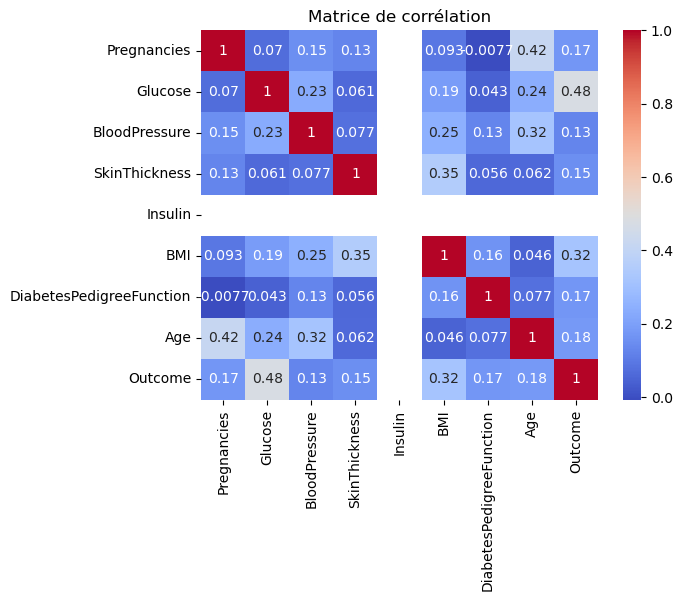

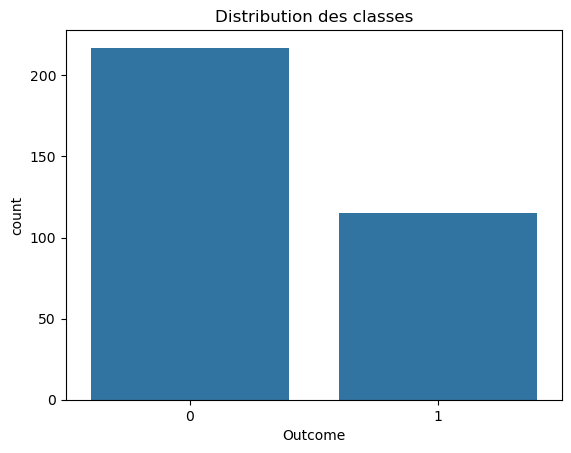

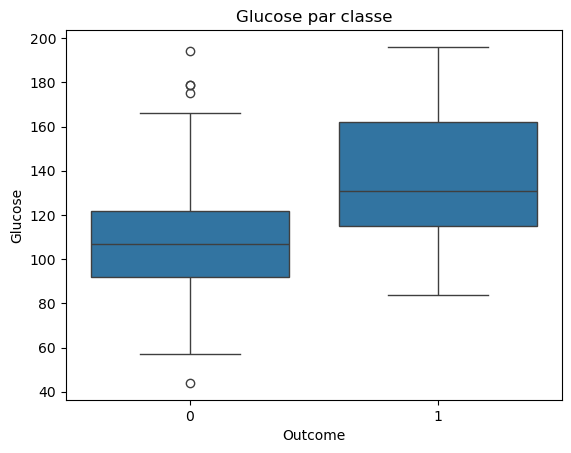

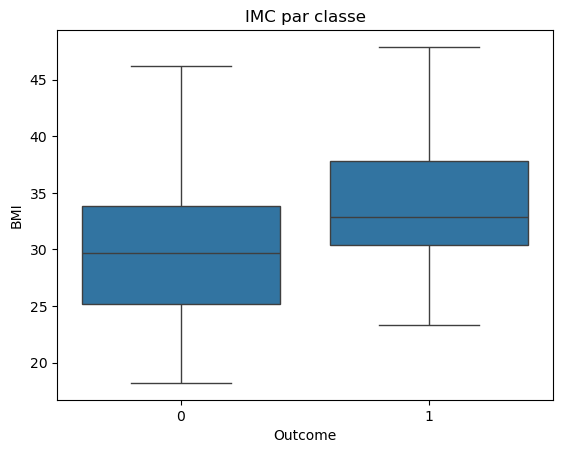

In [5]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

sns.countplot(x='Outcome', data=df)
plt.title("Distribution des classes")
plt.show()

sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title("Glucose par classe")
plt.show()

sns.boxplot(x='Outcome', y='BMI', data=df)
plt.title("IMC par classe")
plt.show()

# -------------------------
# 5. Préparation des données
# -------------------------

In [6]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# -------------------------
# 6. Entraînement des modèles
# -------------------------

In [7]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# -------------------------
# 7. Évaluation initiale
# -------------------------

In [8]:
models = {'Logistic Regression': y_pred_log, 'Random Forest': y_pred_rf}

for name, preds in models.items():
    print(f"\n=== {name} ===")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))



=== Logistic Regression ===
[[43  1]
 [11 12]]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        44
           1       0.92      0.52      0.67        23

    accuracy                           0.82        67
   macro avg       0.86      0.75      0.77        67
weighted avg       0.84      0.82      0.81        67


=== Random Forest ===
[[39  5]
 [ 9 14]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        44
           1       0.74      0.61      0.67        23

    accuracy                           0.79        67
   macro avg       0.77      0.75      0.76        67
weighted avg       0.79      0.79      0.79        67



# -------------------------
# 8. Optimisation par GridSearchCV
# -------------------------

In [9]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Évaluation finale
y_pred_best = best_model.predict(X_test)
print("\n=== Random Forest Optimisé ===")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Meilleurs hyperparamètres : {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}

=== Random Forest Optimisé ===
[[39  5]
 [ 9 14]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        44
           1       0.74      0.61      0.67        23

    accuracy                           0.79        67
   macro avg       0.77      0.75      0.76        67
weighted avg       0.79      0.79      0.79        67



# -------------------------
# 9. Courbe d'apprentissage
# -------------------------

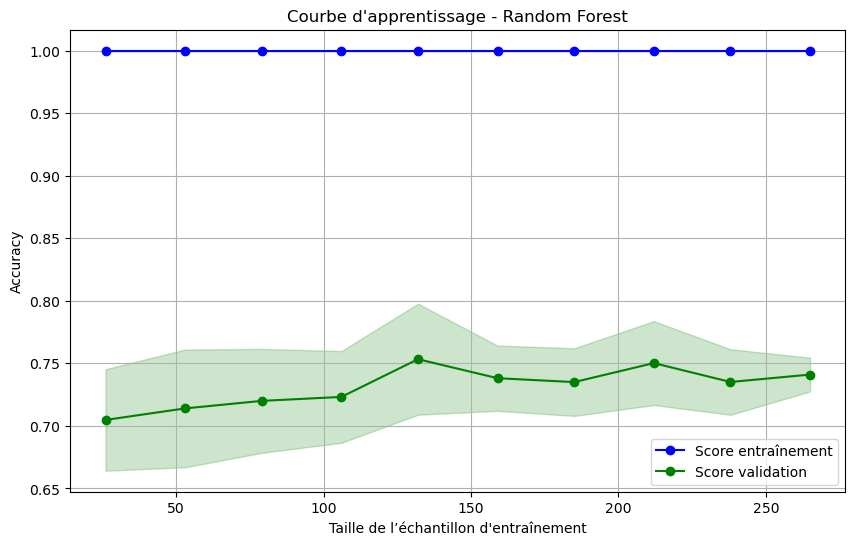

In [10]:

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_scaled,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Score entraînement')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Score validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title("Courbe d'apprentissage - Random Forest")
plt.xlabel("Taille de l’échantillon d'entraînement")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# 10. Sauvegarde des objets
# -------------------------

In [11]:
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ Modèle et scaler sauvegardés avec succès.")


✅ Modèle et scaler sauvegardés avec succès.
